**Steps for Fine-tuning the Model for Batch correct:**

1.  **Prepare Your Environment:** Ensure you have the necessary Python libraries installed (as indicated in the original script).
2.  **Download Datasets and Pre-trained Model:** Obtain the gene and protein expression data files for training and testing, as well as the pre-trained model files.
3.  **Organize File Paths:** Make sure the paths to your data files and the pre-trained model are correctly specified.
4.  **Execute the Python Script:** Run the Python script from your terminal, providing the required parameters to control the fine-tuning process.
5.  **Locate Output Files:** After the script finishes, the fine-tuned model, generated feature files and predicted results will be saved in the directory specified by the `--save_dir` parameter (Please download our dataset, fine-tuned models, generated feature files from https://drive.google.com/drive/folders/1D05clgX57ISVdUozEz-HiQu5t5kEuNpW?usp=drive_link).

**Python Command to Run Fine-tuning:**

```bash
python finetune.py   --token_dict_dir ./token_dict/   --data_rna_path  ./data/pbmc_gene_train.h5ad   --data_adt_path ./data/pbmc_protein_train.h5ad   --save_dir ./results/   --load_model_dir ./CAPTAIN_PBMC/   --species "human" --prior_know ./prior_know/

```
**Python Command to Generate Embedding:**
```bash
python generate_embedding.py --data_dir ./batch_correct/dataset1/ --save_dir ./batch_correct/dataset1/captain/ --vocab_file ./token_dict/vocab.json --token_dict_dir ./token_dict/ --load_model ./CAPTAIN_Base/ --rna_file adata.h5ad --adt_file adata_protein.h5ad --species human
```

**Explanation of the Command:**
--data_dir: Specifies the base directory containing your input datasets (h5ad files).

--save_dir: Sets the directory where the output pickle files (rna_embeddings.pickle and adt_embeddings.pickle) will be saved.

--vocab_file: Provides the path to the gene vocabulary JSON file.

--token_dict_dir: Specifies the directory containing the necessary token dictionaries (human_mouse_align.pickle, etc.).

--load_model: Specifies the directory containing the pre-trained model checkpoint (args.json and .pt file).

--rna_file: The filename of the RNA AnnData object within data_dir (e.g., adata.h5ad).

--adt_file: The filename of the ADT (Protein) AnnData object within data_dir (e.g., adata_protein.h5ad).

--species: Indicates the species (human or mouse) to handle gene name alignment.
Remember to adjust the file paths according to the actual location of your data and pre-trained model. You can also modify other parameters as needed based on your specific requirements.



In [1]:
import omicverse as ov
import scanpy as sc
ov.plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/
Dependency error: The 'bioservices' distribution was not found and is required by the application


In [ ]:
import functools
import json
import logging
import os
from pathlib import Path
import random
import subprocess
from typing import Dict, List, Mapping, Optional, Tuple, Union

import numpy as np
import torch
import pandas as pd
from anndata import AnnData
import scib
from matplotlib import pyplot as plt
from matplotlib import axes
# Wrapper for all scib metrics, we leave out some metrics like hvg_score, cell_cyvle,
# trajectory_conservation, because we only evaluate the latent embeddings here and
# these metrics are evaluating the reconstructed gene expressions or pseudotimes.
def eval_scib_metrics(
    adata: AnnData,
    batch_key: str = "donor",
    label_key: str = "celltype.l2",
    notes: Optional[str] = None,
) -> Dict:
    results = scib.metrics.metrics(
        adata,
        adata_int=adata,
        batch_key=batch_key,
        label_key=label_key,
        embed="X_captain",
        isolated_labels_asw_=False,
        silhouette_=True,
        hvg_score_=False,
        graph_conn_=True,
        pcr_=True,
        isolated_labels_f1_=False,
        trajectory_=False,
        nmi_=True,  # use the clustering, bias to the best matching
        ari_=True,  # use the clustering, bias to the best matching
        cell_cycle_=False,
        kBET_=False,  # kBET return nan sometimes, need to examine
        ilisi_=False,
        clisi_=False,
    )

    if notes is not None:
        print(f"{notes}")

    print(f"{results}")

    result_dict = results[0].to_dict()
    print(
        "Biological Conservation Metrics: \n"
        f"ASW (cell-type): {result_dict['ASW_label']:.4f}, graph cLISI: {result_dict['cLISI']:.4f}, "
        f"isolated label silhouette: {result_dict['isolated_label_silhouette']:.4f}, \n"
        "Batch Effect Removal Metrics: \n"
        f"PCR_batch: {result_dict['PCR_batch']:.4f}, ASW (batch): {result_dict['ASW_label/batch']:.4f}, "
        f"graph connectivity: {result_dict['graph_conn']:.4f}, graph iLISI: {result_dict['iLISI']:.4f}"
    )

    result_dict["avg_bio"] = np.mean(
        [
            result_dict["NMI_cluster/label"],
            result_dict["ARI_cluster/label"],
            result_dict["ASW_label"],
        ]
    )

    # remove nan value in result_dict
    result_dict = {k: v for k, v in result_dict.items() if not np.isnan(v)}

    return result_dict

import pickle as pkl
import numpy as np
with open('./batch_multiomics/dataset1/adt_embeddings.pickle', 'rb') as fp:
    adt_embeddings=pkl.load(fp)
adt_embeddings=np.array(adt_embeddings)

adata=sc.read_h5ad("./batch_multiomics/dataset1/pbmc_gene.h5ad")
adata.obsm["X_captain"] = adt_embeddings

In [3]:
adata.obs['donor']

index
L2_TATCGCCAGTCGGCAA      P1
E2L3_TCGTAGATCCTGGGTG    P5
E2L6_AGCGATTGTTCTATCT    P8
L5_CTGTATTCATCCTAAG      P3
E2L3_TCACTCGCACCGCTGA    P8
                         ..
E2L6_GGGTGTCTCGGACTGC    P5
E2L1_TACACCCGTCACGTGC    P8
L1_TCACGCTAGCTCCGAC      P4
E2L5_TCACTCGTCTAGTGTG    P5
E2L3_CATCCGTTCATTACGG    P7
Name: donor, Length: 12872, dtype: category
Categories (8, object): ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8']

In [4]:
result_dict=eval_scib_metrics(adata)

Recompute neighbors on rep X_captain instead of None
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:38)
Cluster for cluster_0.2 with leiden
running Leiden clustering


/home/jiboya/anaconda3/envs/scgpt_cap/lib/python3.10/site-packages/scib/metrics/clustering.py:96: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  cluster_function(adata, resolution=res, key_added=resolution_key, **kwargs)


    finished: found 9 clusters and added
    'cluster_0.2', the cluster labels (adata.obs, categorical) (0:00:03)
Cluster for cluster_0.4 with leiden
running Leiden clustering
    finished: found 10 clusters and added
    'cluster_0.4', the cluster labels (adata.obs, categorical) (0:00:03)
Cluster for cluster_0.6 with leiden
running Leiden clustering
    finished: found 14 clusters and added
    'cluster_0.6', the cluster labels (adata.obs, categorical) (0:00:05)
Cluster for cluster_0.8 with leiden
running Leiden clustering
    finished: found 18 clusters and added
    'cluster_0.8', the cluster labels (adata.obs, categorical) (0:00:04)
Cluster for cluster_1.0 with leiden
running Leiden clustering
    finished: found 19 clusters and added
    'cluster_1.0', the cluster labels (adata.obs, categorical) (0:00:08)
Cluster for cluster_1.2 with leiden
running Leiden clustering
    finished: found 21 clusters and added
    'cluster_1.2', the cluster labels (adata.obs, categorical) (0:00:03)
C

/home/jiboya/anaconda3/envs/scgpt_cap/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


    finished (0:00:10)
computing PCA
    with n_comps=50


/home/jiboya/anaconda3/envs/scgpt_cap/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


    finished (0:00:00)
Graph connectivity...
                                  0
NMI_cluster/label          0.923880
ARI_cluster/label          0.937773
ASW_label                  0.636335
ASW_label/batch            0.912662
PCR_batch                  0.543621
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.994754
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
Biological Conservation Metrics: 
ASW (cell-type): 0.6363, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.5436, ASW (batch): 0.9127, graph connectivity: 0.9948, graph iLISI: nan


/home/jiboya/anaconda3/envs/scgpt_cap/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/home/jiboya/anaconda3/envs/scgpt_cap/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/home/jiboya/anaconda3/envs/scgpt_cap/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/home/jiboya/anaconda3/envs/scgpt_cap/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future 

In [5]:
result_dict

{'NMI_cluster/label': 0.9238801151311052,
 'ARI_cluster/label': 0.9377728292967411,
 'ASW_label': 0.6363352521958472,
 'ASW_label/batch': 0.9126620977120605,
 'PCR_batch': 0.5436206421154265,
 'graph_conn': 0.9947543400726373,
 'avg_bio': 0.8326627322078979}

computing neighbors
computing PCA
    with n_comps=50


/home/jiboya/anaconda3/envs/scgpt_cap/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 512 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:05)


/home/jiboya/anaconda3/envs/scgpt_cap/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/jiboya/anaconda3/envs/scgpt_cap/lib/python3.10/site-packages/omicverse/utils/_scatterplot.py:1268: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(values) or values.dtype == bool:
/home/jiboya/anaconda3/envs/scgpt_cap/lib/python3.10/site-packages/omicverse/utils/_scatterplot.py:1277: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jiboya/anaconda3/envs/scgpt_cap/lib/

Text(0.5, 1.0, 'Captain, AvgBIO=0.832')

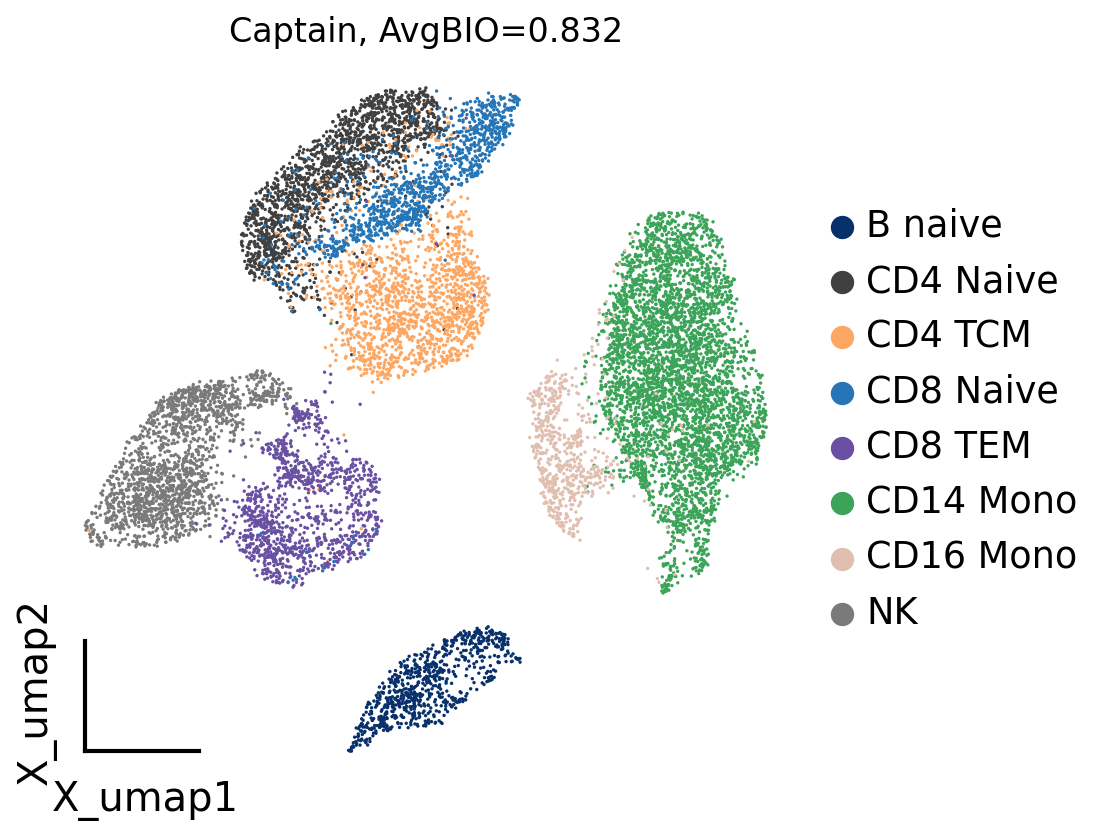

In [6]:
import pickle as pkl
import numpy as np

colors = np.array([ 
    '#3ba458', '#404040', '#7a7a7a', '#fda762', '#6950a3', '#2575b7',
    '#08306b', '#e1bfb0', '#e5d8bd', '#79b5d9', '#f14432', '#fc8a6a',
    '#98d594', '#d0e1f2', '#2E8B57', '#B0A8B9', '#FF7F50', '#6C7A89'
], dtype=object)
cell_types=adata.obs['celltype.l2']
palette = dict(zip(list(cell_types.unique()), colors))

adt_embeddings=np.array(adt_embeddings)
adt_embeddings = sc.AnnData(adt_embeddings)
adt_embeddings.obs=adata.obs

sc.pp.neighbors(adt_embeddings)
sc.tl.umap(adt_embeddings)


import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize = (6,6))
ov.pl.embedding(adt_embeddings,
                basis='X_umap',
               color='celltype.l2',
               frameon='small',
               show=False,
               palette=palette,
               ax=ax,)
plt.title('Captain, AvgBIO=0.832',fontsize=15)

/home/jiboya/anaconda3/envs/scgpt_cap/lib/python3.10/site-packages/omicverse/utils/_scatterplot.py:1268: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(values) or values.dtype == bool:
/home/jiboya/anaconda3/envs/scgpt_cap/lib/python3.10/site-packages/omicverse/utils/_scatterplot.py:1277: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jiboya/anaconda3/envs/scgpt_cap/lib/python3.10/site-packages/omicverse/utils/_scatterplot.py:430: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


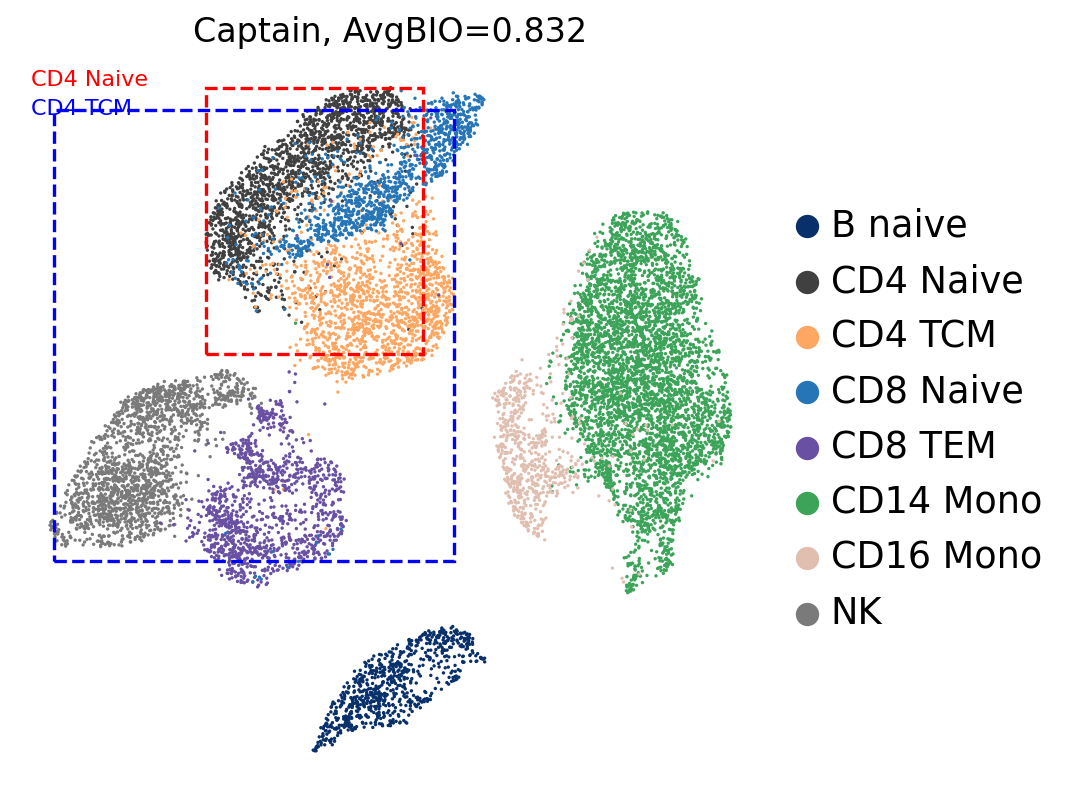

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon
import numpy as np

fig, ax = plt.subplots(figsize=(6, 6))
ov.pl.embedding(adt_embeddings,
                basis='X_umap',
                color='celltype.l2',
                frameon='small',
                show=False,
                palette=palette,
                ax=ax)

# 移除所有坐标轴
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()

# 获取特定细胞类型的坐标范围
def get_cluster_bbox(adata, cluster_name):
    cluster_mask = adata.obs['celltype.l2'] == cluster_name
    x_coords = adata.obsm['X_umap'][cluster_mask, 0]
    y_coords = adata.obsm['X_umap'][cluster_mask, 1]
    return [x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()]

# 为CD4 Naive添加虚线框
cd4_naive_bbox = get_cluster_bbox(adt_embeddings, 'CD4 Naive')
rect_naive = Rectangle((cd4_naive_bbox[0], cd4_naive_bbox[2]), 
                      width=cd4_naive_bbox[1]-cd4_naive_bbox[0],
                      height=cd4_naive_bbox[3]-cd4_naive_bbox[2],
                      linewidth=1.5, linestyle='--',
                      edgecolor='red', facecolor='none')
ax.add_patch(rect_naive)

# 为CD4 TEM添加虚线框
cd4_tem_bbox = get_cluster_bbox(adt_embeddings, 'CD4 TCM')
rect_tem = Rectangle((cd4_tem_bbox[0], cd4_tem_bbox[2]), 
                    width=cd4_tem_bbox[1]-cd4_tem_bbox[0],
                    height=cd4_tem_bbox[3]-cd4_tem_bbox[2],
                    linewidth=1.5, linestyle='--',
                    edgecolor='blue', facecolor='none')
ax.add_patch(rect_tem)

# 添加图例说明
ax.text(0.02, 0.98, 'CD4 Naive', color='red', transform=ax.transAxes, 
        ha='left', va='top', fontsize=10)
ax.text(0.02, 0.94, 'CD4 TCM', color='blue', transform=ax.transAxes, 
        ha='left', va='top', fontsize=10)

plt.title('Captain, AvgBIO=0.832', fontsize=15)
plt.show()

computing neighbors
computing PCA
    with n_comps=50


/home/jiboya/anaconda3/envs/scgpt_cap/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 512 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:05)


/home/jiboya/anaconda3/envs/scgpt_cap/lib/python3.10/site-packages/omicverse/utils/_scatterplot.py:1268: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(values) or values.dtype == bool:
/home/jiboya/anaconda3/envs/scgpt_cap/lib/python3.10/site-packages/omicverse/utils/_scatterplot.py:1277: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jiboya/anaconda3/envs/scgpt_cap/lib/python3.10/site-packages/omicverse/utils/_scatterplot.py:430: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0.5, 1.0, 'Captain, AvgBIO=0.832')

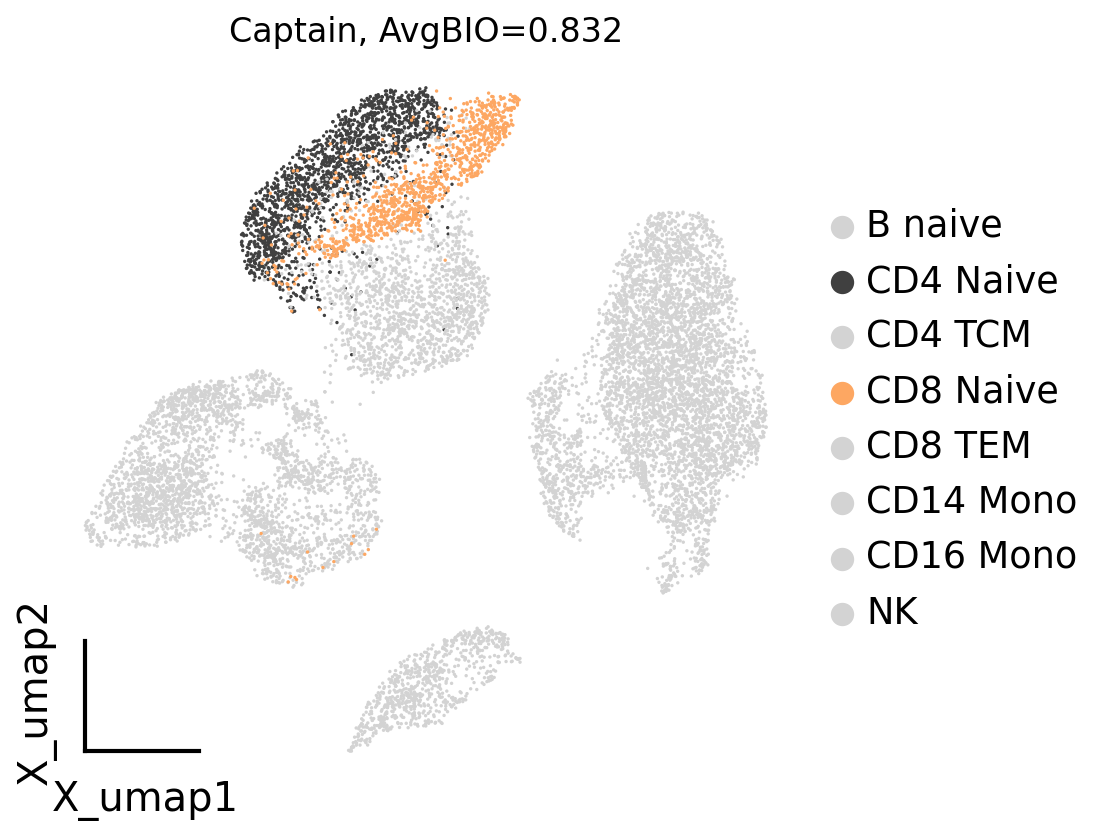

In [15]:
import pickle as pkl
import numpy as np


cell_types=adata.obs['celltype.l2']
palette = {
    'B Naive': '#d3d3d3',
    'CD4 Naive': '#404040',
    'CD4 TCM': '#d3d3d3',
    'CD8 Naive': '#fda762',
    'CD8 TEM': '#d3d3d3',
    'CD14 Mono': '#d3d3d3',
    'CD16 Mono': '#d3d3d3',
    'NK': '#d3d3d3',
    'B naive': '#d3d3d3',
}

adt_embeddings=np.array(adt_embeddings)
adt_embeddings = sc.AnnData(adt_embeddings)
adt_embeddings.obs=adata.obs

sc.pp.neighbors(adt_embeddings)
sc.tl.umap(adt_embeddings)


import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize = (6,6))
ov.pl.embedding(adt_embeddings,
                basis='X_umap',
               color='celltype.l2',
               frameon='small',
               show=False,
               palette=palette,
               ax=ax,)
plt.title('Captain, AvgBIO=0.832',fontsize=15)#只保留CD4和CD8 naive

In [45]:
adata_filtered.obsm

AxisArraysView with keys: X_apca, X_aumap, X_pca, X_spca, X_umap, X_wnn.umap

In [8]:
output_pdf = "dataset01_Captain_0.832_umap_plot.pdf"
plt.savefig(output_pdf, format='pdf', bbox_inches='tight')

print(f"UMAP 图已保存为: {output_pdf}")

UMAP 图已保存为: dataset01_Captain_0.832_umap_plot.pdf


/home/jiboya/anaconda3/envs/scgpt_cap/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


<Figure size 320x320 with 0 Axes>

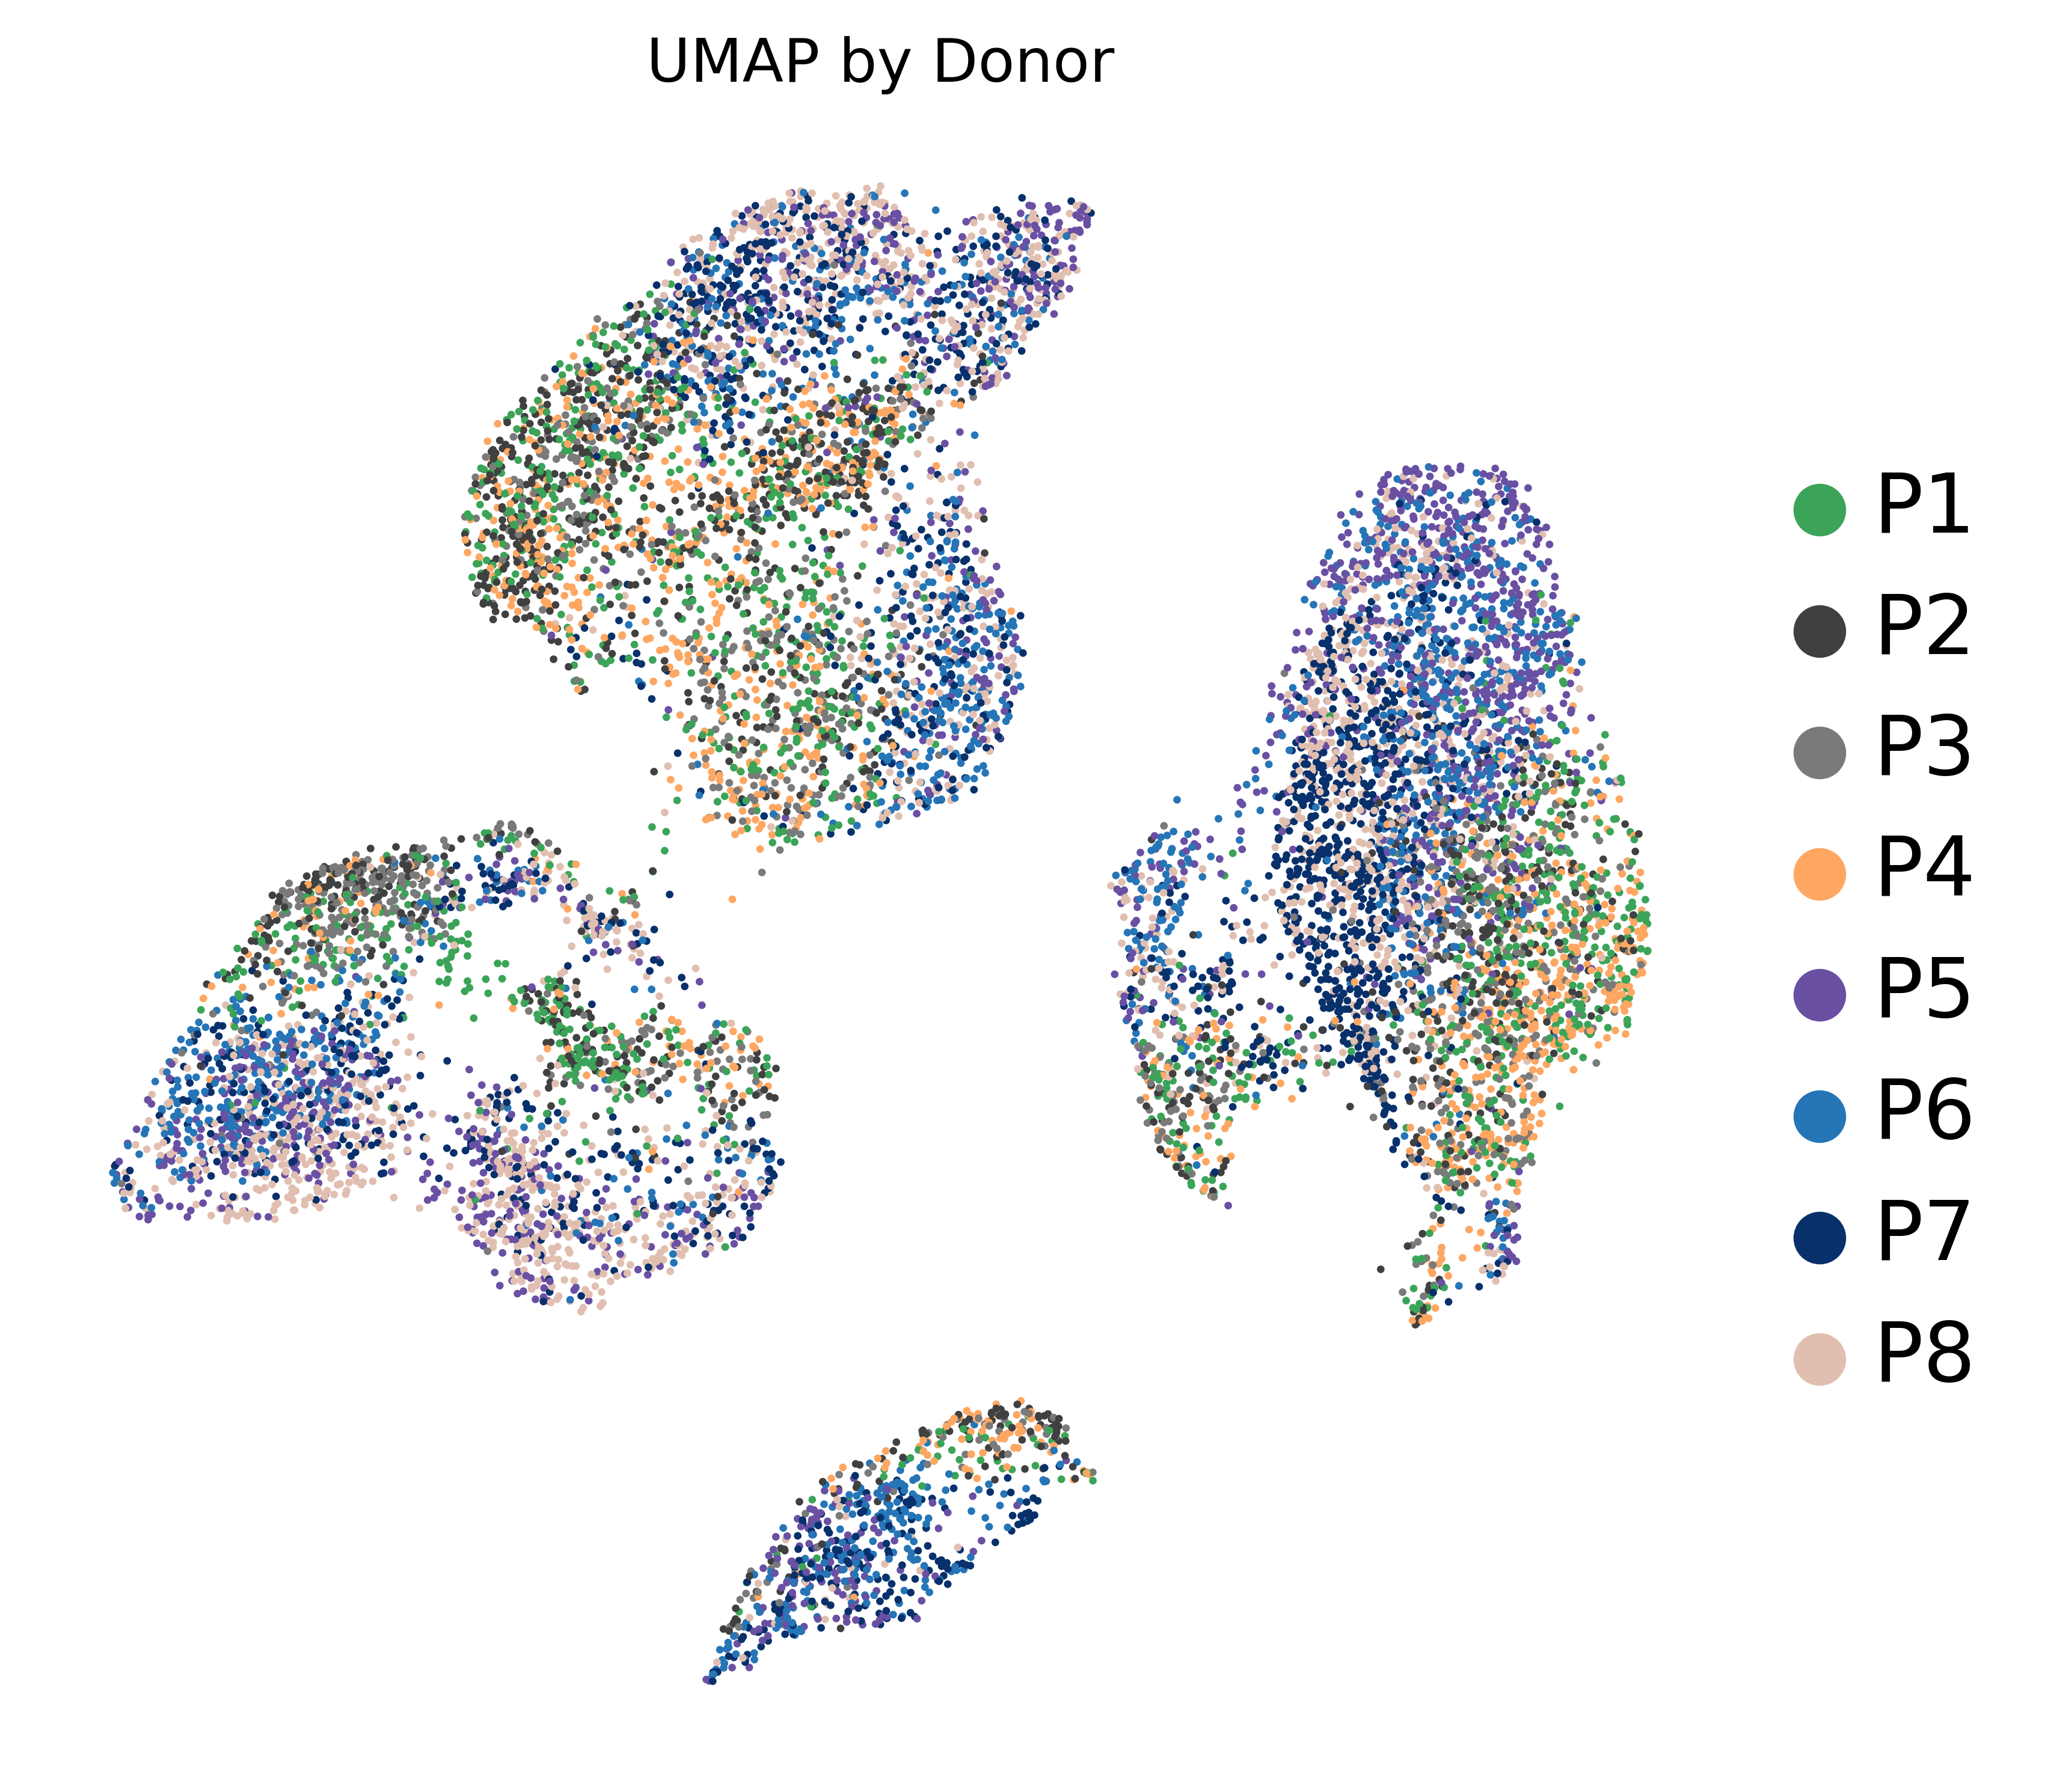

In [19]:

fig, ax = plt.subplots(figsize=(6, 6), dpi=300)


sc.pl.embedding(
    adt_embeddings,
    basis='X_umap',
    color='donor',
    frameon='small',
    show=False,
    palette=palette,
    ax=ax
)


ax.set_xticks([])  
ax.set_yticks([])  
ax.set_axis_off() 


plt.title('UMAP by Donor', fontsize=12)


plt.savefig('umap_by_donor.png', 
           dpi=300, 
           bbox_inches='tight',  
           pad_inches=0.1,       
           transparent=False)    


plt.show()